In [1]:
import pandas as pd
import requests
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

### PIB per cápita de la CDMX

Para este indicador se utilizará el PIB por entidad federativa del INEGI y las proyecciones de población de CONAPO.

In [2]:
pob=pd.read_csv("https://conapo.segob.gob.mx/work/models/CONAPO/Datos_Abiertos/pry23/00_Pob_Mitad_1950_2070.csv")
pob.columns=pob.columns.str.lower()
pob=pob[pob["cve_geo"]==9]
pob=pob.groupby("año").sum("poblacion").reset_index()
#Año y poblacion
pob=pob[["año","poblacion"]]
pob

,año,poblacion
0,1970,7336320
1,1971,7509052
2,1972,7677940
3,1973,7849693
4,1974,8022978
...,...,...
96,2066,6858398
97,2067,6781472
98,2068,6704276
99,2069,6626630


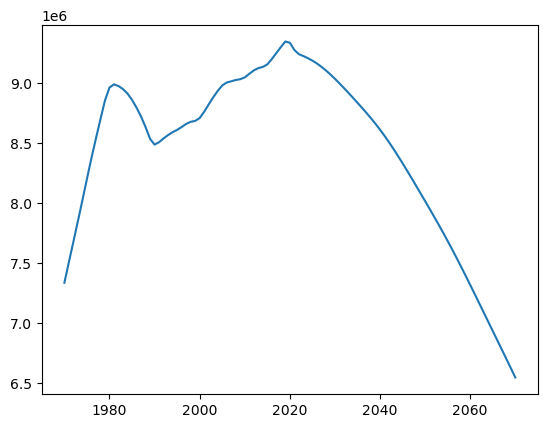

In [3]:
#Gráfica de la población de la CDMX
plt.plot(pob["año"],pob["poblacion"])

### PIB cdmx

In [4]:
### Abrir credenciales

with open ("C:/Users/claud/Documents/credenciales_inegi.txt") as f:
    credenciales=f.read().strip()

In [5]:
url="  https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/746106/es/0700/false/BIE/2.0/"
fin="?type=json"

In [6]:
#Solicitar datos
r=requests.get(url+credenciales+fin)
pib=pd.DataFrame(r.json()["Series"][0]["OBSERVATIONS"])
pib.columns=pib.columns.str.lower()
pib["time_period"]=pib["time_period"].astype(int)
pib['obs_value']=pib['obs_value'].astype(float)
pib=pib[["time_period","obs_value"]]
#Renombrar columnas
pib.columns=["año","pib"]
pib.sort_values("año",ascending=True,inplace=True)
#Calcular tasas de crecimiento
pib["tasa_crecimiento"]=pib["pib"].pct_change().mul(100)
pib

,año,pib,tasa_crecimiento
20,2003,2842788.554,NaN
19,2004,2962342.214,4.205507
18,2005,2991075.244,0.969943
17,2006,3134225.217,4.785903
16,2007,3142463.801,0.262859
15,2008,3183429.429,1.303615
14,2009,3008811.766,-5.485206
13,2010,3125716.691,3.885418
12,2011,3231440.239,3.382378
11,2012,3332208.721,3.118377


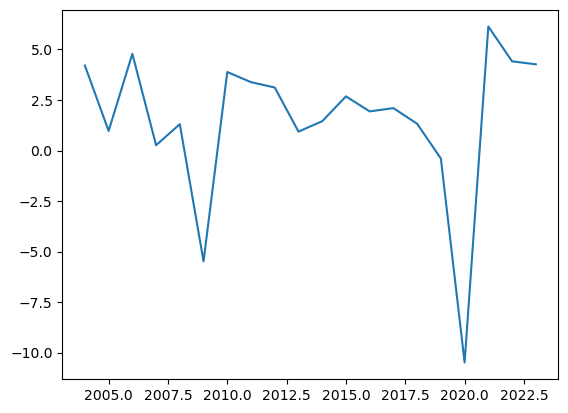

In [7]:
#Graficar tasas de crecimiento
plt.plot(pib["año"],pib["tasa_crecimiento"])

In [8]:
pib_proy=pib.copy()
pib_proy.dropna(inplace=True)

#Regresión lineal clásica

x=pib_proy[["año"]]
y=pib_proy["tasa_crecimiento"]

model=LinearRegression()
model.fit(x,y)

#Predicciones
predict=model.predict(x)
pib_proy["predicciones"]=predict
pib_proy["residuales"]=y-predict
pib_proy

,año,pib,tasa_crecimiento,predicciones,residuales
19,2004,2962342.214,4.205507,1.808920,2.396587
18,2005,2991075.244,0.969943,1.780516,-0.810573
17,2006,3134225.217,4.785903,1.752113,3.033790
16,2007,3142463.801,0.262859,1.723710,-1.460851
15,2008,3183429.429,1.303615,1.695307,-0.391692
14,2009,3008811.766,-5.485206,1.666904,-7.152110
13,2010,3125716.691,3.885418,1.638501,2.246918
12,2011,3231440.239,3.382378,1.610097,1.772280
11,2012,3332208.721,3.118377,1.581694,1.536683
10,2013,3363394.325,0.935884,1.553291,-0.617407


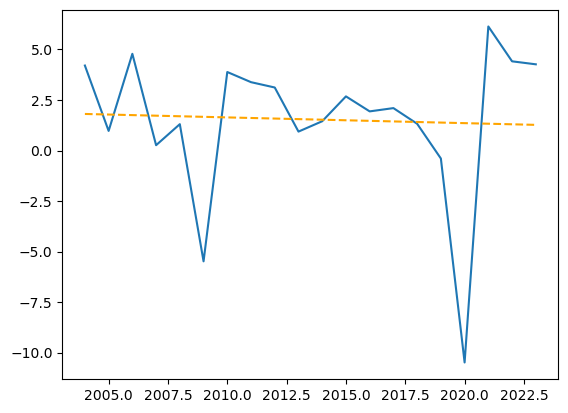

In [9]:
#Gráfica
fig,ax=plt.subplots()
ax.plot(pib_proy["año"],pib_proy["tasa_crecimiento"],label="Tasa de crecimiento del PIB")
ax.plot(pib_proy["año"],pib_proy["predicciones"],linestyle="--",color="orange",label="Predicciones")

In [10]:
#Calcular tasas de crecimiento de 2024 a 2045
future_years=list(range(2024,2046))
historical_values=pib_proy["tasa_crecimiento"].tolist()

#Predecir valores futuros solo utilizando el modelo sin tendencia y sin ruido
for i in range(len(future_years)):
    next_value=model.predict([[future_years[i]]])
    historical_values.append(next_value[0])
    
future_df=pd.DataFrame({"año":future_years,"tasa_crecimiento":historical_values[len(pib_proy):]})
future_df

c:\Users\claud\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\claud\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\claud\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\claud\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\claud\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\claud\minic

,año,tasa_crecimiento
0,2024,1.240856
1,2025,1.212453
2,2026,1.184050
3,2027,1.155646
4,2028,1.127243
5,2029,1.098840
6,2030,1.070437
7,2031,1.042034
8,2032,1.013631
9,2033,0.985227


In [11]:
#Pegar las dos tablas
pib_final=pd.concat([pib,future_df],ignore_index=True)
pib_final

,año,pib,tasa_crecimiento
0,2003,2842788.554,NaN
1,2004,2962342.214,4.205507
2,2005,2991075.244,0.969943
3,2006,3134225.217,4.785903
4,2007,3142463.801,0.262859
5,2008,3183429.429,1.303615
6,2009,3008811.766,-5.485206
7,2010,3125716.691,3.885418
8,2011,3231440.239,3.382378
9,2012,3332208.721,3.118377


In [12]:
#Aplicar tasas de crecimiento
for year in range(2024,2046):
    pib_final.loc[pib_final["año"]==year,"pib"]=pib_final.loc[pib_final["año"]==year-1,"pib"].values[0]*(1+pib_final.loc[pib_final["año"]==year,"tasa_crecimiento"].values[0]/100)
    
pib_final


,año,pib,tasa_crecimiento
0,2003,2.842789e+06,NaN
1,2004,2.962342e+06,4.205507
2,2005,2.991075e+06,0.969943
3,2006,3.134225e+06,4.785903
4,2007,3.142464e+06,0.262859
5,2008,3.183429e+06,1.303615
6,2009,3.008812e+06,-5.485206
7,2010,3.125717e+06,3.885418
8,2011,3.231440e+06,3.382378
9,2012,3.332209e+06,3.118377


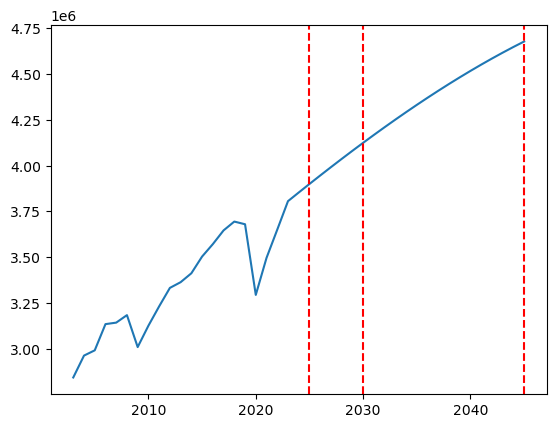

In [13]:
#Gráfica del PIB de la CDMX con proyecciones
fig,ax=plt.subplots()
ax.plot(pib_final["año"],pib_final["pib"])
#Líneas horizontales en 2030, 2025 y 2045
ax.axvline(2025,linestyle="--",color="red")
ax.axvline(2030,linestyle="--",color="red")
ax.axvline(2045,linestyle="--",color="red")

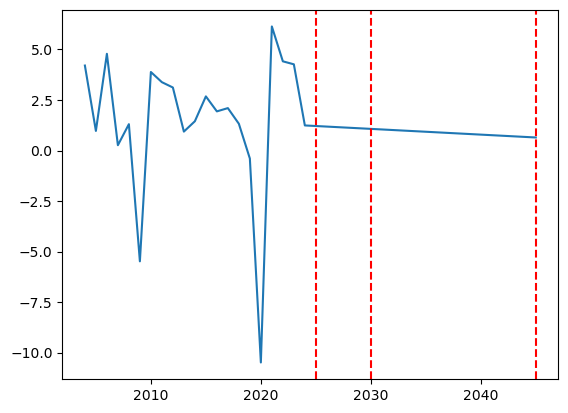

In [14]:
#Graficar tasa de crecimiento
fig,ax=plt.subplots()
ax.plot(pib_final["año"],pib_final["tasa_crecimiento"])
#Líneas horizontales en 2030,2025 y 2045
ax.axvline(2025,linestyle="--",color="red")
ax.axvline(2030,linestyle="--",color="red")
ax.axvline(2045,linestyle="--",color="red")

In [15]:
#Pegar las dos tablas
pibpc=pib_final.merge(pob,on="año")
pibpc["pibpc"]=pibpc["pib"]/(pibpc["poblacion"]/1000000)
pibpc

,año,pib,tasa_crecimiento,poblacion,pibpc
0,2003,2.842789e+06,NaN,8878329,320194.098912
1,2004,2.962342e+06,4.205507,8931633,331668.600132
2,2005,2.991075e+06,0.969943,8977190,333186.135528
3,2006,3.134225e+06,4.785903,9001741,348179.892867
4,2007,3.142464e+06,0.262859,9011907,348701.312719
5,2008,3.183429e+06,1.303615,9022695,352824.674778
6,2009,3.008812e+06,-5.485206,9029228,333230.234744
7,2010,3.125717e+06,3.885418,9044151,345606.424638
8,2011,3.231440e+06,3.382378,9074286,356109.586914
9,2012,3.332209e+06,3.118377,9102171,366089.444046


In [16]:
print("Crecimiento pib per capita 2024 vs 2045: ",
        (pibpc.loc[pibpc["año"] == 2045, "pibpc"].values[0] /
         pibpc.loc[pibpc["año"] == 2024, "pibpc"].values[0] - 1) * 100)

Crecimiento pib per capita 2024 vs 2045:  34.15078124828443


In [17]:
print("Crecimiento pib per capita 2023 vs 2003: ",
        (pibpc.loc[pibpc["año"] == 2023, "pibpc"].values[0] /
         pibpc.loc[pibpc["año"] == 2003, "pibpc"].values[0] - 1) * 100)

Crecimiento pib per capita 2023 vs 2003:  28.901811744355733


In [18]:
pib_final=pd.concat([pib,future_df],ignore_index=True)
pib_final

,año,pib,tasa_crecimiento
0,2003,2842788.554,NaN
1,2004,2962342.214,4.205507
2,2005,2991075.244,0.969943
3,2006,3134225.217,4.785903
4,2007,3142463.801,0.262859
5,2008,3183429.429,1.303615
6,2009,3008811.766,-5.485206
7,2010,3125716.691,3.885418
8,2011,3231440.239,3.382378
9,2012,3332208.721,3.118377


In [19]:
#Aplicar tasas de crecimiento
for year in range(2024,2046):
    pib_final.loc[pib_final["año"]==year,"pib"]=pib_final.loc[pib_final["año"]==year-1,"pib"].values[0]*(1+pib_final.loc[pib_final["año"]==year,"tasa_crecimiento"].values[0]/100)

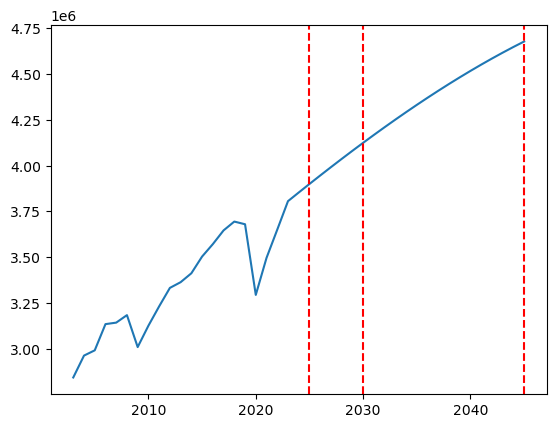

In [20]:
#Gráfica del PIB de la CDMX con proyecciones
fig,ax=plt.subplots()
ax.plot(pib_final["año"],pib_final["pib"])
#Líneas horizontales en 2030, 2025 y 2045
ax.axvline(2025,linestyle="--",color="red")
ax.axvline(2030,linestyle="--",color="red")
ax.axvline(2045,linestyle="--",color="red")

In [21]:
#Pegar las dos tablas
pibpc=pib_final.merge(pob,on="año")
pibpc["pibpc"]=pibpc["pib"]/(pibpc["poblacion"]/1000000)
#guardar en csv
pibpc.to_csv("pibpc_cdmx.csv",index=False)
pibpc

,año,pib,tasa_crecimiento,poblacion,pibpc
0,2003,2.842789e+06,NaN,8878329,320194.098912
1,2004,2.962342e+06,4.205507,8931633,331668.600132
2,2005,2.991075e+06,0.969943,8977190,333186.135528
3,2006,3.134225e+06,4.785903,9001741,348179.892867
4,2007,3.142464e+06,0.262859,9011907,348701.312719
5,2008,3.183429e+06,1.303615,9022695,352824.674778
6,2009,3.008812e+06,-5.485206,9029228,333230.234744
7,2010,3.125717e+06,3.885418,9044151,345606.424638
8,2011,3.231440e+06,3.382378,9074286,356109.586914
9,2012,3.332209e+06,3.118377,9102171,366089.444046


In [22]:
print("Crecimiento pib per capita 2024 vs 2045: ",
      (pibpc.loc[pibpc["año"] == 2045, "pibpc"].values[0] /
       pibpc.loc[pibpc["año"] == 2025, "pibpc"].values[0] - 1) * 100)

Crecimiento pib per capita 2024 vs 2045:  32.250553747931285


In [23]:
print("Crecimiento pib per capita 2023 vs 2003: ",
      (pibpc.loc[pibpc["año"] == 2023, "pibpc"].values[0] /
       pibpc.loc[pibpc["año"] == 2003, "pibpc"].values[0] - 1) * 100)

Crecimiento pib per capita 2023 vs 2003:  28.901811744355733


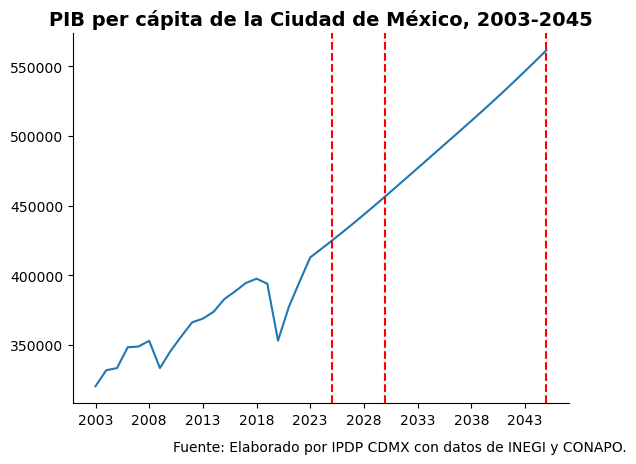

In [24]:
#Gráfica del PIB per cápita
fig,ax=plt.subplots()
ax.plot(pibpc["año"],pibpc["pibpc"])
ax.set_title("PIB per cápita de la Ciudad de México, 2003-2045", fontsize=14, fontweight="bold")
ax.set_xticks(pibpc["año"][::5])
#Líneas en 2030,2035 y 2045
ax.axvline(2025,linestyle="--",color="red")
ax.axvline(2030,linestyle="--",color="red")
ax.axvline(2045,linestyle="--",color="red")
#Eliminar bordes
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#Añadir fuente
plt.figtext(0.99, 0.01, "Fuente: Elaborado por IPDP CDMX con datos de INEGI y CONAPO.", horizontalalignment='right')

#Salvar la gráfica
plt.savefig("pibp_per_capita_cdmx.png",dpi=300,bbox_inches="tight")

In [25]:
#Mostrar valores 2023,2030,2035 y 2045
pibpc.loc[pibpc["año"].isin([2023,2030,2035,2045])]

,año,pib,tasa_crecimiento,poblacion,pibpc
20,2023,3.806102e+06,4.265967,9221637,412735.994596
27,2030,4.124875e+06,1.070437,9032705,456659.999323
32,2035,4.332114e+06,0.928421,8833389,490424.897258
42,2045,4.678493e+06,0.644389,8330174,561632.101905


### Inversión extranjera directa

Para este indicador se utilizarán los datos de la Secretaría de Economía. El indicador es el porcentaje de la inversión extranjera directa en la Ciudad de México respecto al total nacional.

In [26]:
#Total
ied_total=pd.read_excel("https://www.gob.mx/cms/uploads/attachment/file/960653/Flujosportipodeinversion.xlsx",skiprows=1
                        )
#Renombrar primera columna como "concepto"
ied_total.columns=["concepto"]+list(ied_total.columns[1:])
#Filtrar concepto=="Total"
ied_total=ied_total[ied_total["concepto"]=="Total"]
ied_total.columns = ied_total.columns.astype(str)
#Conservar columnas que contengan la palabra "Total"
ied_total = ied_total.loc[:, ied_total.columns.str.contains("Total", case=False)]
#Eliminar última columna
ied_total=ied_total.iloc[:,:-1]
#llevar a long
ied_total=ied_total.melt(var_name="año",value_name="ied_total")
#Eliminar la palabra total de año y dejar solo número
ied_total["año"]=ied_total["año"].str.replace("Total ","")
ied_total["año"]=pd.to_numeric(ied_total["año"])
ied_total

,año,ied_total
0,2006,21236.364768
1,2007,32393.536492
2,2008,29503.881496
3,2009,17850.518081
4,2010,27189.992184
5,2011,25632.526157
6,2012,21769.332132
7,2013,48354.429681
8,2014,30351.281828
9,2015,35943.853207


In [27]:
ied_cdmx=pd.read_excel("https://www.gob.mx/cms/uploads/attachment/file/960652/Flujosporentidadfederativa.xlsx",skiprows=6,sheet_name="CDMX",nrows=5)
#Primera columna renombrarla como "concepto"
ied_cdmx.columns=["concepto"]+list(ied_cdmx.columns[1:])
ied_cdmx.columns=ied_cdmx.columns.astype(str)
ied_cdmx=ied_cdmx[ied_cdmx["concepto"]=="Total"]
ied_cdmx=ied_cdmx.loc[:,ied_cdmx.columns.str.contains("Total",case=False)]
ied_cdmx=ied_cdmx.iloc[:,:-1]
ied_cdmx=ied_cdmx.melt(var_name="año",value_name="ied_cdmx")
#Eliminar la palabra total de año y dejar solo número
ied_cdmx["año"]=ied_cdmx["año"].str.replace("Total ","")
ied_cdmx["año"]=pd.to_numeric(ied_cdmx["año"])

ied_cdmx

,año,ied_cdmx
0,2006,5671.130318
1,2007,6931.542673
2,2008,7724.065395
3,2009,5254.643944
4,2010,4064.564035
5,2011,7507.596454
6,2012,1337.463057
7,2013,5835.336662
8,2014,6126.781376
9,2015,5909.157065


In [28]:
#Pegar ieds
ieds=ied_total.merge(ied_cdmx, on="año")
#Calcular porcentaje
ieds["porcentaje"]=ieds["ied_cdmx"]/ieds["ied_total"]*100

print("Valor máximo de ied_cdmx: ",ieds["porcentaje"].max())
print("Valor mínimo de ied_cdmx: ",ieds["porcentaje"].min())
ieds

Valor máximo de ied_cdmx:  44.15023453359373
Valor mínimo de ied_cdmx:  6.143794623536813


,año,ied_total,ied_cdmx,porcentaje
0,2006,21236.364768,5671.130318,26.704807
1,2007,32393.536492,6931.542673,21.397919
2,2008,29503.881496,7724.065395,26.179828
3,2009,17850.518081,5254.643944,29.436927
4,2010,27189.992184,4064.564035,14.948750
5,2011,25632.526157,7507.596454,29.289335
6,2012,21769.332132,1337.463057,6.143795
7,2013,48354.429681,5835.336662,12.067843
8,2014,30351.281828,6126.781376,20.186236
9,2015,35943.853207,5909.157065,16.439965


In [29]:
# Calcular media móvil
window_size = 3  
ieds['moving_avg'] = ieds['porcentaje'].rolling(window=window_size, min_periods=1).mean()

years = np.arange(len(ieds))
trend = np.polyfit(years, ieds['porcentaje'], 1)[0]  #Línea de tendencia
std_dev = ieds['porcentaje'].std()
future_years = list(range(2024, 2046))
historical_values = ieds['porcentaje'].tolist()

for i in range(len(future_years)):
    # Calcular valores futuros
    trend_effect = trend * (len(historical_values) - len(ieds))  
    random_effect = np.random.normal(0, std_dev * 0.1) #Añadir ruido
    next_value = np.mean(historical_values[-window_size:]) + random_effect#+trend_effect
    historical_values.append(next_value)

# Dataframe con valores futuros
future_df = pd.DataFrame({'año': future_years, 'porcentaje': historical_values[len(ieds):]})

# Combinar con datos históricos
ieds_final = pd.concat([ieds[['año', 'porcentaje']], future_df], ignore_index=True)
ieds_final.to_csv("ied_cdmx.csv",index=False)
ieds_final

,año,porcentaje
0,2006,26.704807
1,2007,21.397919
2,2008,26.179828
3,2009,29.436927
4,2010,14.948750
5,2011,29.289335
6,2012,6.143795
7,2013,12.067843
8,2014,20.186236
9,2015,16.439965


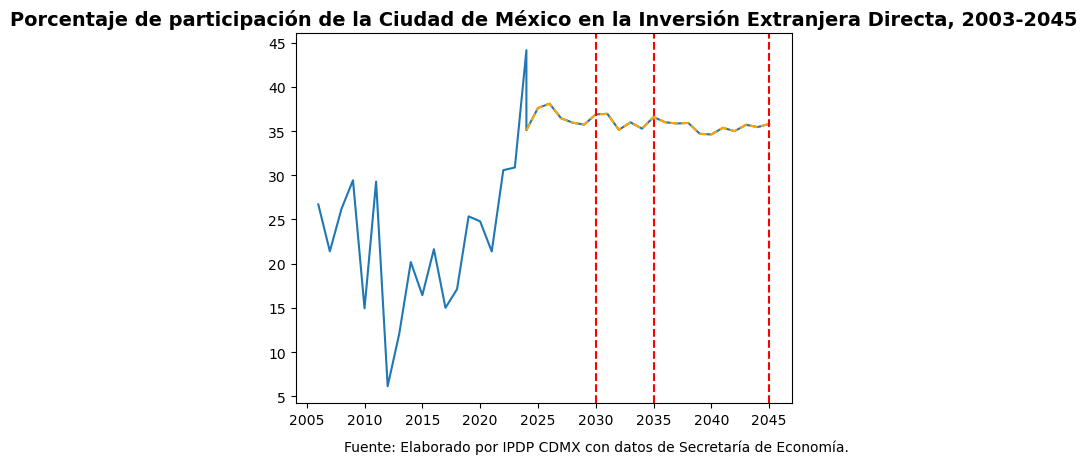

In [30]:
# Gráfica
fig, ax = plt.subplots()

ax.plot(ieds_final['año'], ieds_final['porcentaje'], label='Porcentaje de la ied en la CDMX')
ax.plot(future_df['año'], future_df['porcentaje'], linestyle='--', color='orange', label='Proyección')
#Graficar poniendo lineas horizontales en 2030,2035 y 2045
ax.axvline(2030,linestyle="--",color="red")
ax.axvline(2035,linestyle="--",color="red")
ax.axvline(2045,linestyle="--",color="red")
#Título
ax.set_title("Porcentaje de participación de la Ciudad de México en la Inversión Extranjera Directa, 2003-2045", fontsize=14, fontweight="bold")
#Fuente
plt.figtext(0.99, 0.01, "Fuente: Elaborado por IPDP CDMX con datos de Secretaría de Economía.", horizontalalignment='right')
#Salvar gráfica
plt.savefig("ied_cdmx.png",dpi=300,bbox_inches="tight")

In [31]:
ieds_final.loc[ieds_final["año"].isin([2023,2024,2030,2035,2045])]

,año,porcentaje
17,2023,30.880790
18,2024,44.150235
19,2024,35.114614
25,2030,36.890452
30,2035,36.591568
40,2045,35.814561
